In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

print(tf.VERSION)
print(tf.keras.__version__)

1.13.1
2.2.4-tf


Loading the data of the [SLAC dataset](http://jmir.sourceforge.net/Codaich.html), with 250 MIDI files. The dataset is equally balanced over the classes.

The vectors are computed using [midi2vec](https://github.com/midi-ld/midi2vec).

The dataset provides 2 kind of classes (genres and subgenres), respectively of 5 and 10 elements:

- Blues
    - Modern Blues
    - Traditional Blues
- Classical
    - Baroque
    - Romantic
- Jazz
    - Bop
    - Swing
- Rap
    - Hardcore Rap
    - Pop Rap
- Rock
    - Alternative Rock
    - Metal

In [2]:
data = np.loadtxt('./dataset-slac/vectors.txt')
genres = np.loadtxt('./dataset-slac/genre.txt', dtype=np.str, delimiter=',')
subgenres = np.loadtxt('./dataset-slac/subgenre.txt', dtype=np.str, delimiter=',')

The labels are represented with the 1-hot encoding

In [3]:
encoder = LabelBinarizer()
def onehot_labels(labels):
    return encoder.fit_transform(labels)
    
def onehot2str(onehot):
    return encoder.inverse_transform(np.array([onehot]))[0]

In [4]:
# source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # one hot to index
    y_true = [np.where(r==1)[0][0] for r in y_true]
    # y_pred are already indexes
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = np.unique(classes)
    classes = classes[unique_labels(y_true, y_pred)]
    classes = [c[0:10] if len(c) > 10 else c for c in classes]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### Experiment 1: Genres 

In [5]:
labels_1hot = onehot_labels(genres)
    
onehot2str(labels_1hot[0])

'Classical'

In [6]:
data.shape

(250, 100)

In [7]:
labels_1hot.shape

(250, 5)

In [8]:
num_input = data.shape[1]
num_output = labels_1hot.shape[1]

num_input, num_output

(100, 5)

We use a Neural Network with 3 dense layers, trained with the Adam Optimizer.

In [9]:
def create_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(100, activation='relu', input_shape=(num_input,)))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(num_output, activation='sigmoid'))

    model.compile(optimizer=tf.train.AdamOptimizer(0.01),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [10]:
neural_network = KerasClassifier(build_fn=create_model, 
                                 epochs=100, 
                                 batch_size=32)

The network is evaluated with 10-fold cross-validation. The final score is the average of the results.

In [11]:
random_state = 2111
scores = cross_val_score(neural_network, data, labels_1hot, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)
scores

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
225/225 [==============================] - 0s 680us/sample - loss: 0.5248 - acc: 0.7484
Epoch 2/100
225/225 [==============================] - 0s 52us/sample - loss: 0.2789 - acc: 0.8942
Epoch 3/100
225/225 [==============================] - 0s 52us/sample - loss: 0.1658 - acc: 0.9342
Epoch 4/100
225/225 [==============================] - 0s 59us/sample - loss: 0.0857 - acc: 0.9724
Epoch 5/100
225/225 [==============================] - 0s 55us/sample - loss: 0.0496 - acc: 0.9822
Epoch 6/100
225/225 [==============================] - 0s 52us/sample - loss: 0.0246 - acc: 0.9938
Epoch 7/100
225/225 [==============================] - 0s 48us/sample - loss: 0.0122 - acc: 0.9982
Epoch 8/100
225/225 [==============================] - 0s 50us/sample - loss: 0.0060 - acc: 0.9991
Epoch 9/100
225/225 [==============================] - 0s 51us/sample - loss: 0.0040 - 

225/225 [==============================] - 0s 53us/sample - loss: 2.3495e-05 - acc: 1.0000
Epoch 75/100
225/225 [==============================] - 0s 53us/sample - loss: 2.3059e-05 - acc: 1.0000
Epoch 76/100
225/225 [==============================] - 0s 53us/sample - loss: 2.2419e-05 - acc: 1.0000
Epoch 77/100
225/225 [==============================] - 0s 51us/sample - loss: 2.1331e-05 - acc: 1.0000
Epoch 78/100
225/225 [==============================] - 0s 52us/sample - loss: 2.0645e-05 - acc: 1.0000
Epoch 79/100
225/225 [==============================] - 0s 53us/sample - loss: 2.0018e-05 - acc: 1.0000
Epoch 80/100
225/225 [==============================] - 0s 52us/sample - loss: 1.9565e-05 - acc: 1.0000
Epoch 81/100
225/225 [==============================] - 0s 52us/sample - loss: 1.9007e-05 - acc: 1.0000
Epoch 82/100
225/225 [==============================] - 0s 50us/sample - loss: 1.8501e-05 - acc: 1.0000
Epoch 83/100
225/225 [==============================] - 0s 56us/sample - loss

225/225 [==============================] - 0s 49us/sample - loss: 4.2999e-05 - acc: 1.0000
Epoch 53/100
225/225 [==============================] - 0s 56us/sample - loss: 4.1657e-05 - acc: 1.0000
Epoch 54/100
225/225 [==============================] - 0s 53us/sample - loss: 4.0441e-05 - acc: 1.0000
Epoch 55/100
225/225 [==============================] - 0s 54us/sample - loss: 3.9405e-05 - acc: 1.0000
Epoch 56/100
225/225 [==============================] - 0s 51us/sample - loss: 3.9098e-05 - acc: 1.0000
Epoch 57/100
225/225 [==============================] - 0s 56us/sample - loss: 3.8210e-05 - acc: 1.0000
Epoch 58/100
225/225 [==============================] - 0s 54us/sample - loss: 3.6637e-05 - acc: 1.0000
Epoch 59/100
225/225 [==============================] - 0s 54us/sample - loss: 3.5103e-05 - acc: 1.0000
Epoch 60/100
225/225 [==============================] - 0s 50us/sample - loss: 3.4022e-05 - acc: 1.0000
Epoch 61/100
225/225 [==============================] - 0s 58us/sample - loss

225/225 [==============================] - 0s 67us/sample - loss: 1.5953e-04 - acc: 1.0000
Epoch 31/100
225/225 [==============================] - 0s 59us/sample - loss: 1.5292e-04 - acc: 1.0000
Epoch 32/100
225/225 [==============================] - 0s 61us/sample - loss: 1.4521e-04 - acc: 1.0000
Epoch 33/100
225/225 [==============================] - 0s 55us/sample - loss: 1.3605e-04 - acc: 1.0000
Epoch 34/100
225/225 [==============================] - 0s 59us/sample - loss: 1.3266e-04 - acc: 1.0000
Epoch 35/100
225/225 [==============================] - 0s 62us/sample - loss: 1.2441e-04 - acc: 1.0000
Epoch 36/100
225/225 [==============================] - 0s 54us/sample - loss: 1.1812e-04 - acc: 1.0000
Epoch 37/100
225/225 [==============================] - 0s 54us/sample - loss: 1.1209e-04 - acc: 1.0000
Epoch 38/100
225/225 [==============================] - 0s 52us/sample - loss: 1.0799e-04 - acc: 1.0000
Epoch 39/100
225/225 [==============================] - 0s 60us/sample - loss

225/225 [==============================] - 0s 54us/sample - loss: 0.0126 - acc: 0.9982
Epoch 9/100
225/225 [==============================] - 0s 53us/sample - loss: 0.0059 - acc: 0.9991
Epoch 10/100
225/225 [==============================] - 0s 52us/sample - loss: 0.0049 - acc: 0.9991
Epoch 11/100
225/225 [==============================] - 0s 52us/sample - loss: 0.0034 - acc: 0.9991
Epoch 12/100
225/225 [==============================] - 0s 55us/sample - loss: 0.0022 - acc: 1.0000
Epoch 13/100
225/225 [==============================] - 0s 54us/sample - loss: 0.0020 - acc: 0.9991
Epoch 14/100
225/225 [==============================] - 0s 55us/sample - loss: 0.0012 - acc: 1.0000
Epoch 15/100
225/225 [==============================] - 0s 53us/sample - loss: 0.0011 - acc: 1.0000
Epoch 16/100
225/225 [==============================] - 0s 58us/sample - loss: 7.7211e-04 - acc: 1.0000
Epoch 17/100
225/225 [==============================] - 0s 54us/sample - loss: 6.5100e-04 - acc: 1.0000
Epoch 

225/225 [==============================] - 0s 61us/sample - loss: 1.9013e-05 - acc: 1.0000
Epoch 88/100
225/225 [==============================] - 0s 53us/sample - loss: 1.8636e-05 - acc: 1.0000
Epoch 89/100
225/225 [==============================] - 0s 61us/sample - loss: 1.8234e-05 - acc: 1.0000
Epoch 90/100
225/225 [==============================] - 0s 54us/sample - loss: 1.7772e-05 - acc: 1.0000
Epoch 91/100
225/225 [==============================] - 0s 53us/sample - loss: 1.7529e-05 - acc: 1.0000
Epoch 92/100
225/225 [==============================] - 0s 56us/sample - loss: 1.7117e-05 - acc: 1.0000
Epoch 93/100
225/225 [==============================] - 0s 56us/sample - loss: 1.6895e-05 - acc: 1.0000
Epoch 94/100
225/225 [==============================] - 0s 58us/sample - loss: 1.6516e-05 - acc: 1.0000
Epoch 95/100
225/225 [==============================] - 0s 53us/sample - loss: 1.6131e-05 - acc: 1.0000
Epoch 96/100
225/225 [==============================] - 0s 53us/sample - loss

225/225 [==============================] - 0s 57us/sample - loss: 3.1576e-05 - acc: 1.0000
Epoch 66/100
225/225 [==============================] - 0s 58us/sample - loss: 3.0602e-05 - acc: 1.0000
Epoch 67/100
225/225 [==============================] - 0s 55us/sample - loss: 2.9732e-05 - acc: 1.0000
Epoch 68/100
225/225 [==============================] - 0s 57us/sample - loss: 2.8883e-05 - acc: 1.0000
Epoch 69/100
225/225 [==============================] - 0s 56us/sample - loss: 2.8064e-05 - acc: 1.0000
Epoch 70/100
225/225 [==============================] - 0s 61us/sample - loss: 2.7375e-05 - acc: 1.0000
Epoch 71/100
225/225 [==============================] - 0s 56us/sample - loss: 2.6729e-05 - acc: 1.0000
Epoch 72/100
225/225 [==============================] - 0s 59us/sample - loss: 2.5713e-05 - acc: 1.0000
Epoch 73/100
225/225 [==============================] - 0s 56us/sample - loss: 2.5125e-05 - acc: 1.0000
Epoch 74/100
225/225 [==============================] - 0s 55us/sample - loss

225/225 [==============================] - 0s 67us/sample - loss: 6.5824e-05 - acc: 1.0000
Epoch 44/100
225/225 [==============================] - 0s 62us/sample - loss: 6.2649e-05 - acc: 1.0000
Epoch 45/100
225/225 [==============================] - 0s 58us/sample - loss: 6.1615e-05 - acc: 1.0000
Epoch 46/100
225/225 [==============================] - 0s 60us/sample - loss: 5.9191e-05 - acc: 1.0000
Epoch 47/100
225/225 [==============================] - 0s 55us/sample - loss: 5.6083e-05 - acc: 1.0000
Epoch 48/100
225/225 [==============================] - 0s 63us/sample - loss: 5.4669e-05 - acc: 1.0000
Epoch 49/100
225/225 [==============================] - 0s 61us/sample - loss: 5.5413e-05 - acc: 1.0000
Epoch 50/100
225/225 [==============================] - 0s 54us/sample - loss: 5.1311e-05 - acc: 1.0000
Epoch 51/100
225/225 [==============================] - 0s 56us/sample - loss: 5.0045e-05 - acc: 1.0000
Epoch 52/100
225/225 [==============================] - 0s 60us/sample - loss

225/225 [==============================] - 0s 59us/sample - loss: 2.2907e-04 - acc: 1.0000
Epoch 22/100
225/225 [==============================] - 0s 57us/sample - loss: 2.0853e-04 - acc: 1.0000
Epoch 23/100
225/225 [==============================] - 0s 54us/sample - loss: 1.9067e-04 - acc: 1.0000
Epoch 24/100
225/225 [==============================] - 0s 55us/sample - loss: 1.7389e-04 - acc: 1.0000
Epoch 25/100
225/225 [==============================] - 0s 56us/sample - loss: 1.6101e-04 - acc: 1.0000
Epoch 26/100
225/225 [==============================] - 0s 57us/sample - loss: 1.4873e-04 - acc: 1.0000
Epoch 27/100
225/225 [==============================] - 0s 56us/sample - loss: 1.3676e-04 - acc: 1.0000
Epoch 28/100
225/225 [==============================] - 0s 55us/sample - loss: 1.2787e-04 - acc: 1.0000
Epoch 29/100
225/225 [==============================] - 0s 54us/sample - loss: 1.2020e-04 - acc: 1.0000
Epoch 30/100
225/225 [==============================] - 0s 56us/sample - loss

225/225 [==============================] - 0s 59us/sample - loss: 8.6105e-06 - acc: 1.0000
Epoch 100/100
25/25 [==============================] - 0s 4ms/sample - loss: 0.8711 - acc: 0.8880
Epoch 1/100
225/225 [==============================] - 0s 899us/sample - loss: 0.5239 - acc: 0.7609
Epoch 2/100
225/225 [==============================] - 0s 57us/sample - loss: 0.2954 - acc: 0.8880
Epoch 3/100
225/225 [==============================] - 0s 56us/sample - loss: 0.1483 - acc: 0.9396
Epoch 4/100
225/225 [==============================] - 0s 56us/sample - loss: 0.0706 - acc: 0.9769
Epoch 5/100
225/225 [==============================] - 0s 55us/sample - loss: 0.0333 - acc: 0.9929
Epoch 6/100
225/225 [==============================] - 0s 56us/sample - loss: 0.0366 - acc: 0.9911
Epoch 7/100
225/225 [==============================] - 0s 55us/sample - loss: 0.0200 - acc: 0.9929
Epoch 8/100
225/225 [==============================] - 0s 54us/sample - loss: 0.0079 - acc: 0.9973
Epoch 9/100
225/22

225/225 [==============================] - 0s 58us/sample - loss: 3.2771e-05 - acc: 1.0000
Epoch 78/100
225/225 [==============================] - 0s 56us/sample - loss: 3.1934e-05 - acc: 1.0000
Epoch 79/100
225/225 [==============================] - 0s 60us/sample - loss: 3.1071e-05 - acc: 1.0000
Epoch 80/100
225/225 [==============================] - 0s 55us/sample - loss: 3.0310e-05 - acc: 1.0000
Epoch 81/100
225/225 [==============================] - 0s 57us/sample - loss: 2.9713e-05 - acc: 1.0000
Epoch 82/100
225/225 [==============================] - 0s 55us/sample - loss: 2.9007e-05 - acc: 1.0000
Epoch 83/100
225/225 [==============================] - 0s 57us/sample - loss: 2.8444e-05 - acc: 1.0000
Epoch 84/100
225/225 [==============================] - 0s 59us/sample - loss: 2.7855e-05 - acc: 1.0000
Epoch 85/100
225/225 [==============================] - 0s 57us/sample - loss: 2.7194e-05 - acc: 1.0000
Epoch 86/100
225/225 [==============================] - 0s 57us/sample - loss

225/225 [==============================] - 0s 55us/sample - loss: 6.6985e-05 - acc: 1.0000
Epoch 56/100
225/225 [==============================] - 0s 58us/sample - loss: 6.4693e-05 - acc: 1.0000
Epoch 57/100
225/225 [==============================] - 0s 59us/sample - loss: 6.2519e-05 - acc: 1.0000
Epoch 58/100
225/225 [==============================] - 0s 60us/sample - loss: 6.0574e-05 - acc: 1.0000
Epoch 59/100
225/225 [==============================] - 0s 57us/sample - loss: 6.3464e-05 - acc: 1.0000
Epoch 60/100
225/225 [==============================] - 0s 55us/sample - loss: 1.3139e-04 - acc: 1.0000
Epoch 61/100
225/225 [==============================] - 0s 58us/sample - loss: 6.2509e-05 - acc: 1.0000
Epoch 62/100
225/225 [==============================] - 0s 59us/sample - loss: 5.4169e-05 - acc: 1.0000
Epoch 63/100
225/225 [==============================] - 0s 57us/sample - loss: 5.1003e-05 - acc: 1.0000
Epoch 64/100
225/225 [==============================] - 0s 54us/sample - loss

225/225 [==============================] - 0s 57us/sample - loss: 5.6962e-05 - acc: 1.0000
Epoch 34/100
225/225 [==============================] - 0s 56us/sample - loss: 5.4574e-05 - acc: 1.0000
Epoch 35/100
225/225 [==============================] - 0s 58us/sample - loss: 5.2471e-05 - acc: 1.0000
Epoch 36/100
225/225 [==============================] - 0s 59us/sample - loss: 5.0002e-05 - acc: 1.0000
Epoch 37/100
225/225 [==============================] - 0s 54us/sample - loss: 4.7840e-05 - acc: 1.0000
Epoch 38/100
225/225 [==============================] - 0s 56us/sample - loss: 4.5911e-05 - acc: 1.0000
Epoch 39/100
225/225 [==============================] - 0s 57us/sample - loss: 4.3880e-05 - acc: 1.0000
Epoch 40/100
225/225 [==============================] - 0s 59us/sample - loss: 4.2393e-05 - acc: 1.0000
Epoch 41/100
225/225 [==============================] - 0s 61us/sample - loss: 4.0864e-05 - acc: 1.0000
Epoch 42/100
225/225 [==============================] - 0s 53us/sample - loss

array([0.93599999, 0.93599999, 0.92000002, 0.99199998, 0.95199996,
       0.88      , 0.88799995, 0.92000002, 0.92799997, 0.84800005])

In [12]:
np.mean(scores)

0.9199999928474426

In [13]:
predicted = cross_val_predict(neural_network, data, labels_1hot, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)

Epoch 1/100
225/225 [==============================] - 0s 1ms/sample - loss: 0.4832 - acc: 0.8000
Epoch 2/100
225/225 [==============================] - 0s 54us/sample - loss: 0.2278 - acc: 0.9316
Epoch 3/100
225/225 [==============================] - 0s 63us/sample - loss: 0.1262 - acc: 0.9476
Epoch 4/100
225/225 [==============================] - 0s 59us/sample - loss: 0.0903 - acc: 0.9662
Epoch 5/100
225/225 [==============================] - 0s 68us/sample - loss: 0.0621 - acc: 0.9778
Epoch 6/100
225/225 [==============================] - 0s 83us/sample - loss: 0.0265 - acc: 0.9938
Epoch 7/100
225/225 [==============================] - 0s 62us/sample - loss: 0.0247 - acc: 0.9947
Epoch 8/100
225/225 [==============================] - 0s 64us/sample - loss: 0.0147 - acc: 0.9956
Epoch 9/100
225/225 [==============================] - 0s 72us/sample - loss: 0.0058 - acc: 0.9991
Epoch 10/100
225/225 [==============================] - 0s 65us/sample - loss: 0.0038 - acc: 0.9991
Epoch 11/1

225/225 [==============================] - 0s 60us/sample - loss: 2.8192e-05 - acc: 1.0000
Epoch 81/100
225/225 [==============================] - 0s 60us/sample - loss: 2.2214e-05 - acc: 1.0000
Epoch 82/100
225/225 [==============================] - 0s 59us/sample - loss: 2.5509e-05 - acc: 1.0000
Epoch 83/100
225/225 [==============================] - 0s 69us/sample - loss: 3.0994e-05 - acc: 1.0000
Epoch 84/100
225/225 [==============================] - 0s 62us/sample - loss: 2.9155e-05 - acc: 1.0000
Epoch 85/100
225/225 [==============================] - 0s 62us/sample - loss: 2.3857e-05 - acc: 1.0000
Epoch 86/100
225/225 [==============================] - 0s 58us/sample - loss: 2.1777e-05 - acc: 1.0000
Epoch 87/100
225/225 [==============================] - 0s 67us/sample - loss: 1.9152e-05 - acc: 1.0000
Epoch 88/100
225/225 [==============================] - 0s 61us/sample - loss: 1.8060e-05 - acc: 1.0000
Epoch 89/100
225/225 [==============================] - 0s 63us/sample - loss

225/225 [==============================] - 0s 62us/sample - loss: 4.3122e-05 - acc: 1.0000
Epoch 60/100
225/225 [==============================] - 0s 66us/sample - loss: 4.1362e-05 - acc: 1.0000
Epoch 61/100
225/225 [==============================] - 0s 60us/sample - loss: 4.0197e-05 - acc: 1.0000
Epoch 62/100
225/225 [==============================] - 0s 60us/sample - loss: 3.9236e-05 - acc: 1.0000
Epoch 63/100
225/225 [==============================] - 0s 59us/sample - loss: 3.8061e-05 - acc: 1.0000
Epoch 64/100
225/225 [==============================] - 0s 61us/sample - loss: 3.7053e-05 - acc: 1.0000
Epoch 65/100
225/225 [==============================] - 0s 65us/sample - loss: 3.6058e-05 - acc: 1.0000
Epoch 66/100
225/225 [==============================] - 0s 63us/sample - loss: 4.5118e-05 - acc: 1.0000
Epoch 67/100
225/225 [==============================] - 0s 62us/sample - loss: 7.3967e-05 - acc: 1.0000
Epoch 68/100
225/225 [==============================] - 0s 60us/sample - loss

225/225 [==============================] - 0s 69us/sample - loss: 4.8159e-05 - acc: 1.0000
Epoch 39/100
225/225 [==============================] - 0s 67us/sample - loss: 4.4865e-05 - acc: 1.0000
Epoch 40/100
225/225 [==============================] - 0s 73us/sample - loss: 4.2361e-05 - acc: 1.0000
Epoch 41/100
225/225 [==============================] - 0s 72us/sample - loss: 4.0753e-05 - acc: 1.0000
Epoch 42/100
225/225 [==============================] - 0s 68us/sample - loss: 3.9105e-05 - acc: 1.0000
Epoch 43/100
225/225 [==============================] - 0s 66us/sample - loss: 3.7569e-05 - acc: 1.0000
Epoch 44/100
225/225 [==============================] - 0s 69us/sample - loss: 3.6317e-05 - acc: 1.0000
Epoch 45/100
225/225 [==============================] - 0s 68us/sample - loss: 3.4791e-05 - acc: 1.0000
Epoch 46/100
225/225 [==============================] - 0s 84us/sample - loss: 3.3758e-05 - acc: 1.0000
Epoch 47/100
225/225 [==============================] - 0s 84us/sample - loss

225/225 [==============================] - 0s 65us/sample - loss: 8.1063e-04 - acc: 1.0000
Epoch 18/100
225/225 [==============================] - 0s 64us/sample - loss: 7.4085e-04 - acc: 1.0000
Epoch 19/100
225/225 [==============================] - 0s 63us/sample - loss: 6.1947e-04 - acc: 1.0000
Epoch 20/100
225/225 [==============================] - 0s 63us/sample - loss: 5.4286e-04 - acc: 1.0000
Epoch 21/100
225/225 [==============================] - 0s 65us/sample - loss: 4.7586e-04 - acc: 1.0000
Epoch 22/100
225/225 [==============================] - 0s 64us/sample - loss: 4.1273e-04 - acc: 1.0000
Epoch 23/100
225/225 [==============================] - 0s 61us/sample - loss: 3.6477e-04 - acc: 1.0000
Epoch 24/100
225/225 [==============================] - 0s 68us/sample - loss: 3.2890e-04 - acc: 1.0000
Epoch 25/100
225/225 [==============================] - 0s 62us/sample - loss: 2.9599e-04 - acc: 1.0000
Epoch 26/100
225/225 [==============================] - 0s 58us/sample - loss

225/225 [==============================] - 0s 60us/sample - loss: 1.8569e-05 - acc: 1.0000
Epoch 96/100
225/225 [==============================] - 0s 56us/sample - loss: 1.8231e-05 - acc: 1.0000
Epoch 97/100
225/225 [==============================] - 0s 60us/sample - loss: 1.7877e-05 - acc: 1.0000
Epoch 98/100
225/225 [==============================] - 0s 57us/sample - loss: 1.7499e-05 - acc: 1.0000
Epoch 99/100
225/225 [==============================] - 0s 56us/sample - loss: 1.7114e-05 - acc: 1.0000
Epoch 100/100
225/225 [==============================] - 0s 61us/sample - loss: 1.6808e-05 - acc: 1.0000
Epoch 1/100
225/225 [==============================] - 0s 1ms/sample - loss: 0.4711 - acc: 0.7742
Epoch 2/100
225/225 [==============================] - 0s 64us/sample - loss: 0.2467 - acc: 0.9058
Epoch 3/100
225/225 [==============================] - 0s 68us/sample - loss: 0.1551 - acc: 0.9431
Epoch 4/100
225/225 [==============================] - 0s 59us/sample - loss: 0.1118 - acc: 

225/225 [==============================] - 0s 64us/sample - loss: 4.2597e-05 - acc: 1.0000
Epoch 75/100
225/225 [==============================] - 0s 65us/sample - loss: 4.1302e-05 - acc: 1.0000
Epoch 76/100
225/225 [==============================] - 0s 63us/sample - loss: 4.0103e-05 - acc: 1.0000
Epoch 77/100
225/225 [==============================] - 0s 64us/sample - loss: 3.9101e-05 - acc: 1.0000
Epoch 78/100
225/225 [==============================] - 0s 65us/sample - loss: 3.8122e-05 - acc: 1.0000
Epoch 79/100
225/225 [==============================] - 0s 63us/sample - loss: 3.7285e-05 - acc: 1.0000
Epoch 80/100
225/225 [==============================] - 0s 66us/sample - loss: 3.6499e-05 - acc: 1.0000
Epoch 81/100
225/225 [==============================] - 0s 58us/sample - loss: 3.5582e-05 - acc: 1.0000
Epoch 82/100
225/225 [==============================] - 0s 64us/sample - loss: 3.4582e-05 - acc: 1.0000
Epoch 83/100
225/225 [==============================] - 0s 68us/sample - loss

225/225 [==============================] - 0s 62us/sample - loss: 6.0306e-05 - acc: 1.0000
Epoch 54/100
225/225 [==============================] - 0s 63us/sample - loss: 5.6062e-05 - acc: 1.0000
Epoch 55/100
225/225 [==============================] - 0s 64us/sample - loss: 5.2988e-05 - acc: 1.0000
Epoch 56/100
225/225 [==============================] - 0s 63us/sample - loss: 4.9993e-05 - acc: 1.0000
Epoch 57/100
225/225 [==============================] - 0s 61us/sample - loss: 4.7233e-05 - acc: 1.0000
Epoch 58/100
225/225 [==============================] - 0s 59us/sample - loss: 4.4820e-05 - acc: 1.0000
Epoch 59/100
225/225 [==============================] - 0s 59us/sample - loss: 4.2799e-05 - acc: 1.0000
Epoch 60/100
225/225 [==============================] - 0s 65us/sample - loss: 4.0687e-05 - acc: 1.0000
Epoch 61/100
225/225 [==============================] - 0s 65us/sample - loss: 3.8780e-05 - acc: 1.0000
Epoch 62/100
225/225 [==============================] - 0s 66us/sample - loss

225/225 [==============================] - 0s 65us/sample - loss: 1.3407e-04 - acc: 1.0000
Epoch 33/100
225/225 [==============================] - 0s 66us/sample - loss: 1.2510e-04 - acc: 1.0000
Epoch 34/100
225/225 [==============================] - 0s 81us/sample - loss: 1.1733e-04 - acc: 1.0000
Epoch 35/100
225/225 [==============================] - 0s 59us/sample - loss: 1.1198e-04 - acc: 1.0000
Epoch 36/100
225/225 [==============================] - 0s 67us/sample - loss: 1.0471e-04 - acc: 1.0000
Epoch 37/100
225/225 [==============================] - 0s 66us/sample - loss: 1.0140e-04 - acc: 1.0000
Epoch 38/100
225/225 [==============================] - 0s 67us/sample - loss: 9.7917e-05 - acc: 1.0000
Epoch 39/100
225/225 [==============================] - 0s 64us/sample - loss: 9.2907e-05 - acc: 1.0000
Epoch 40/100
225/225 [==============================] - 0s 68us/sample - loss: 8.7495e-05 - acc: 1.0000
Epoch 41/100
225/225 [==============================] - 0s 64us/sample - loss

225/225 [==============================] - 0s 62us/sample - loss: 0.0013 - acc: 1.0000
Epoch 12/100
225/225 [==============================] - 0s 82us/sample - loss: 0.0014 - acc: 1.0000
Epoch 13/100
225/225 [==============================] - 0s 75us/sample - loss: 9.2087e-04 - acc: 1.0000
Epoch 14/100
225/225 [==============================] - 0s 66us/sample - loss: 8.1216e-04 - acc: 1.0000
Epoch 15/100
225/225 [==============================] - 0s 58us/sample - loss: 5.7540e-04 - acc: 1.0000
Epoch 16/100
225/225 [==============================] - 0s 55us/sample - loss: 4.8536e-04 - acc: 1.0000
Epoch 17/100
225/225 [==============================] - 0s 66us/sample - loss: 4.2257e-04 - acc: 1.0000
Epoch 18/100
225/225 [==============================] - 0s 66us/sample - loss: 3.5996e-04 - acc: 1.0000
Epoch 19/100
225/225 [==============================] - 0s 72us/sample - loss: 3.2963e-04 - acc: 1.0000
Epoch 20/100
225/225 [==============================] - 0s 87us/sample - loss: 3.0607

Epoch 90/100
225/225 [==============================] - 0s 60us/sample - loss: 1.2402e-05 - acc: 1.0000
Epoch 91/100
225/225 [==============================] - 0s 62us/sample - loss: 1.2161e-05 - acc: 1.0000
Epoch 92/100
225/225 [==============================] - 0s 88us/sample - loss: 1.1989e-05 - acc: 1.0000
Epoch 93/100
225/225 [==============================] - 0s 84us/sample - loss: 1.1739e-05 - acc: 1.0000
Epoch 94/100
225/225 [==============================] - 0s 74us/sample - loss: 1.1515e-05 - acc: 1.0000
Epoch 95/100
225/225 [==============================] - 0s 77us/sample - loss: 1.1283e-05 - acc: 1.0000
Epoch 96/100
225/225 [==============================] - 0s 117us/sample - loss: 1.1102e-05 - acc: 1.0000
Epoch 97/100
225/225 [==============================] - 0s 78us/sample - loss: 1.1494e-05 - acc: 1.0000
Epoch 98/100
225/225 [==============================] - 0s 78us/sample - loss: 1.1894e-05 - acc: 1.0000
Epoch 99/100
225/225 [==============================] - 0s 59us

225/225 [==============================] - 0s 82us/sample - loss: 2.7926e-05 - acc: 1.0000
Epoch 70/100
225/225 [==============================] - 0s 97us/sample - loss: 2.7236e-05 - acc: 1.0000
Epoch 71/100
225/225 [==============================] - 0s 86us/sample - loss: 2.6594e-05 - acc: 1.0000
Epoch 72/100
225/225 [==============================] - 0s 97us/sample - loss: 2.6167e-05 - acc: 1.0000
Epoch 73/100
225/225 [==============================] - 0s 82us/sample - loss: 2.5474e-05 - acc: 1.0000
Epoch 74/100
225/225 [==============================] - 0s 71us/sample - loss: 2.4798e-05 - acc: 1.0000
Epoch 75/100
225/225 [==============================] - 0s 72us/sample - loss: 2.4167e-05 - acc: 1.0000
Epoch 76/100
225/225 [==============================] - 0s 77us/sample - loss: 2.3577e-05 - acc: 1.0000
Epoch 77/100
225/225 [==============================] - 0s 80us/sample - loss: 2.3096e-05 - acc: 1.0000
Epoch 78/100
225/225 [==============================] - 0s 74us/sample - loss

225/225 [==============================] - 0s 73us/sample - loss: 4.5688e-05 - acc: 1.0000
Epoch 49/100
225/225 [==============================] - 0s 62us/sample - loss: 4.5003e-05 - acc: 1.0000
Epoch 50/100
225/225 [==============================] - 0s 70us/sample - loss: 4.3686e-05 - acc: 1.0000
Epoch 51/100
225/225 [==============================] - 0s 64us/sample - loss: 4.1899e-05 - acc: 1.0000
Epoch 52/100
225/225 [==============================] - 0s 68us/sample - loss: 4.0121e-05 - acc: 1.0000
Epoch 53/100
225/225 [==============================] - 0s 63us/sample - loss: 3.8570e-05 - acc: 1.0000
Epoch 54/100
225/225 [==============================] - 0s 68us/sample - loss: 3.7251e-05 - acc: 1.0000
Epoch 55/100
225/225 [==============================] - 0s 67us/sample - loss: 3.6008e-05 - acc: 1.0000
Epoch 56/100
225/225 [==============================] - 0s 64us/sample - loss: 3.5018e-05 - acc: 1.0000
Epoch 57/100
225/225 [==============================] - 0s 71us/sample - loss

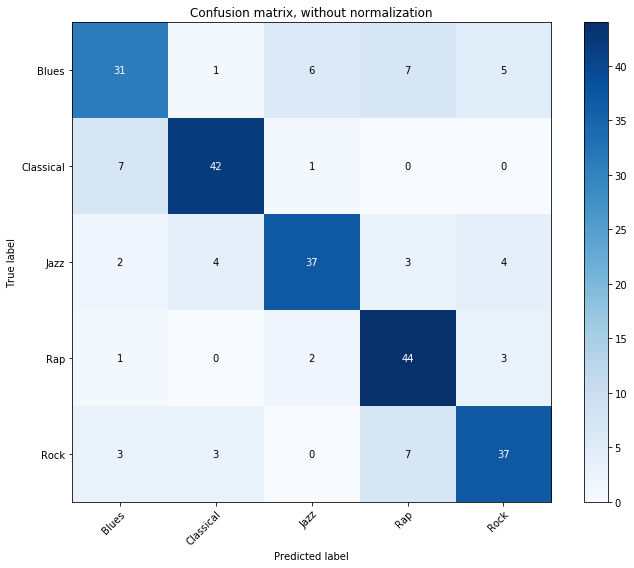

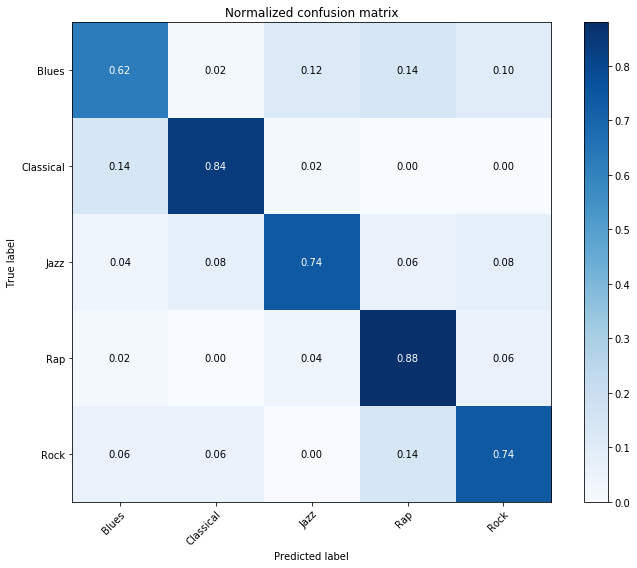

In [14]:
np.set_printoptions(precision=2)
plot_confusion_matrix(labels_1hot, predicted, classes=genres,
                      title='Confusion matrix, without normalization')
plot_confusion_matrix(labels_1hot, predicted, classes=genres, normalize=True,
                      title='Normalized confusion matrix')

### Experiment 2: Subgenres 

The experiment is the same, but applied to the 10 subgenre classes.

In [15]:
labels_1hot = onehot_labels(subgenres)
    
onehot2str(labels_1hot[0])

'Romantic'

In [16]:
num_output = labels_1hot.shape[1]

num_input, num_output

(100, 10)

In [17]:
neural_network = KerasClassifier(build_fn=create_model, 
                                 epochs=100, 
                                 batch_size=32)

In [18]:
scores = cross_val_score(neural_network, data, labels_1hot, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)
scores

Epoch 1/100
225/225 [==============================] - 0s 1ms/sample - loss: 0.4378 - acc: 0.8316
Epoch 2/100
225/225 [==============================] - 0s 72us/sample - loss: 0.2653 - acc: 0.9031
Epoch 3/100
225/225 [==============================] - 0s 74us/sample - loss: 0.1769 - acc: 0.9267
Epoch 4/100
225/225 [==============================] - 0s 76us/sample - loss: 0.1280 - acc: 0.9511
Epoch 5/100
225/225 [==============================] - 0s 74us/sample - loss: 0.0865 - acc: 0.9689
Epoch 6/100
225/225 [==============================] - 0s 70us/sample - loss: 0.0628 - acc: 0.9804
Epoch 7/100
225/225 [==============================] - 0s 73us/sample - loss: 0.0377 - acc: 0.9876
Epoch 8/100
225/225 [==============================] - 0s 74us/sample - loss: 0.0357 - acc: 0.9916
Epoch 9/100
225/225 [==============================] - 0s 77us/sample - loss: 0.0237 - acc: 0.9938
Epoch 10/100
225/225 [==============================] - 0s 74us/sample - loss: 0.0122 - acc: 0.9987
Epoch 11/1

Epoch 81/100
225/225 [==============================] - 0s 64us/sample - loss: 6.4621e-05 - acc: 1.0000
Epoch 82/100
225/225 [==============================] - 0s 64us/sample - loss: 6.2988e-05 - acc: 1.0000
Epoch 83/100
225/225 [==============================] - 0s 61us/sample - loss: 6.1637e-05 - acc: 1.0000
Epoch 84/100
225/225 [==============================] - 0s 64us/sample - loss: 6.0046e-05 - acc: 1.0000
Epoch 85/100
225/225 [==============================] - 0s 71us/sample - loss: 5.8722e-05 - acc: 1.0000
Epoch 86/100
225/225 [==============================] - 0s 73us/sample - loss: 5.7510e-05 - acc: 1.0000
Epoch 87/100
225/225 [==============================] - 0s 71us/sample - loss: 5.6216e-05 - acc: 1.0000
Epoch 88/100
225/225 [==============================] - 0s 64us/sample - loss: 5.5008e-05 - acc: 1.0000
Epoch 89/100
225/225 [==============================] - 0s 71us/sample - loss: 5.3938e-05 - acc: 1.0000
Epoch 90/100
225/225 [==============================] - 0s 74us/

225/225 [==============================] - 0s 71us/sample - loss: 8.4150e-05 - acc: 1.0000
Epoch 60/100
225/225 [==============================] - 0s 74us/sample - loss: 8.1350e-05 - acc: 1.0000
Epoch 61/100
225/225 [==============================] - 0s 70us/sample - loss: 7.8506e-05 - acc: 1.0000
Epoch 62/100
225/225 [==============================] - 0s 68us/sample - loss: 7.6530e-05 - acc: 1.0000
Epoch 63/100
225/225 [==============================] - 0s 69us/sample - loss: 7.3818e-05 - acc: 1.0000
Epoch 64/100
225/225 [==============================] - 0s 67us/sample - loss: 7.2102e-05 - acc: 1.0000
Epoch 65/100
225/225 [==============================] - 0s 65us/sample - loss: 7.0600e-05 - acc: 1.0000
Epoch 66/100
225/225 [==============================] - 0s 67us/sample - loss: 6.8714e-05 - acc: 1.0000
Epoch 67/100
225/225 [==============================] - 0s 77us/sample - loss: 6.7095e-05 - acc: 1.0000
Epoch 68/100
225/225 [==============================] - 0s 92us/sample - loss

225/225 [==============================] - 0s 69us/sample - loss: 5.8469e-04 - acc: 1.0000
Epoch 39/100
225/225 [==============================] - 0s 71us/sample - loss: 0.0011 - acc: 0.9991
Epoch 40/100
225/225 [==============================] - 0s 70us/sample - loss: 7.9242e-04 - acc: 0.9996
Epoch 41/100
225/225 [==============================] - 0s 70us/sample - loss: 3.5109e-04 - acc: 1.0000
Epoch 42/100
225/225 [==============================] - 0s 69us/sample - loss: 3.1347e-04 - acc: 1.0000
Epoch 43/100
225/225 [==============================] - 0s 66us/sample - loss: 3.0668e-04 - acc: 1.0000
Epoch 44/100
225/225 [==============================] - 0s 70us/sample - loss: 2.6108e-04 - acc: 1.0000
Epoch 45/100
225/225 [==============================] - 0s 71us/sample - loss: 2.6292e-04 - acc: 1.0000
Epoch 46/100
225/225 [==============================] - 0s 66us/sample - loss: 2.8887e-04 - acc: 1.0000
Epoch 47/100
225/225 [==============================] - 0s 67us/sample - loss: 2.

225/225 [==============================] - 0s 60us/sample - loss: 0.0052 - acc: 0.9987
Epoch 17/100
225/225 [==============================] - 0s 62us/sample - loss: 0.0055 - acc: 0.9991
Epoch 18/100
225/225 [==============================] - 0s 60us/sample - loss: 0.0034 - acc: 0.9991
Epoch 19/100
225/225 [==============================] - 0s 60us/sample - loss: 0.0044 - acc: 0.9987
Epoch 20/100
225/225 [==============================] - 0s 62us/sample - loss: 0.0025 - acc: 0.9991
Epoch 21/100
225/225 [==============================] - 0s 61us/sample - loss: 0.0034 - acc: 0.9991
Epoch 22/100
225/225 [==============================] - 0s 68us/sample - loss: 0.0017 - acc: 0.9996
Epoch 23/100
225/225 [==============================] - 0s 61us/sample - loss: 0.0022 - acc: 0.9991
Epoch 24/100
225/225 [==============================] - 0s 64us/sample - loss: 0.0016 - acc: 0.9996
Epoch 25/100
225/225 [==============================] - 0s 60us/sample - loss: 0.0012 - acc: 0.9996
Epoch 26/100


225/225 [==============================] - 0s 59us/sample - loss: 4.1817e-05 - acc: 1.0000
Epoch 96/100
225/225 [==============================] - 0s 60us/sample - loss: 4.0859e-05 - acc: 1.0000
Epoch 97/100
225/225 [==============================] - 0s 71us/sample - loss: 4.2608e-05 - acc: 1.0000
Epoch 98/100
225/225 [==============================] - 0s 60us/sample - loss: 3.9418e-05 - acc: 1.0000
Epoch 99/100
225/225 [==============================] - 0s 66us/sample - loss: 3.9201e-05 - acc: 1.0000
Epoch 100/100
25/25 [==============================] - 0s 9ms/sample - loss: 0.3805 - acc: 0.9360
Epoch 1/100
225/225 [==============================] - 0s 2ms/sample - loss: 0.4291 - acc: 0.8316
Epoch 2/100
225/225 [==============================] - 0s 65us/sample - loss: 0.2710 - acc: 0.9018
Epoch 3/100
225/225 [==============================] - 0s 63us/sample - loss: 0.1919 - acc: 0.9187
Epoch 4/100
225/225 [==============================] - 0s 72us/sample - loss: 0.1265 - acc: 0.9569


225/225 [==============================] - 0s 62us/sample - loss: 5.9821e-04 - acc: 1.0000
Epoch 76/100
225/225 [==============================] - 0s 78us/sample - loss: 5.0968e-04 - acc: 1.0000
Epoch 77/100
225/225 [==============================] - 0s 64us/sample - loss: 5.0729e-04 - acc: 1.0000
Epoch 78/100
225/225 [==============================] - 0s 73us/sample - loss: 3.7621e-04 - acc: 1.0000
Epoch 79/100
225/225 [==============================] - 0s 63us/sample - loss: 4.4368e-04 - acc: 1.0000
Epoch 80/100
225/225 [==============================] - 0s 69us/sample - loss: 4.0857e-04 - acc: 1.0000
Epoch 81/100
225/225 [==============================] - 0s 74us/sample - loss: 3.6069e-04 - acc: 1.0000
Epoch 82/100
225/225 [==============================] - 0s 64us/sample - loss: 3.8781e-04 - acc: 1.0000
Epoch 83/100
225/225 [==============================] - 0s 78us/sample - loss: 2.6426e-04 - acc: 1.0000
Epoch 84/100
225/225 [==============================] - 0s 63us/sample - loss

225/225 [==============================] - 0s 77us/sample - loss: 5.0349e-04 - acc: 1.0000
Epoch 55/100
225/225 [==============================] - 0s 75us/sample - loss: 4.9292e-04 - acc: 1.0000
Epoch 56/100
225/225 [==============================] - 0s 75us/sample - loss: 3.1531e-04 - acc: 1.0000
Epoch 57/100
225/225 [==============================] - 0s 79us/sample - loss: 3.4246e-04 - acc: 1.0000
Epoch 58/100
225/225 [==============================] - 0s 76us/sample - loss: 2.1688e-04 - acc: 1.0000
Epoch 59/100
225/225 [==============================] - 0s 80us/sample - loss: 3.2257e-04 - acc: 1.0000
Epoch 60/100
225/225 [==============================] - 0s 78us/sample - loss: 2.0641e-04 - acc: 1.0000
Epoch 61/100
225/225 [==============================] - 0s 72us/sample - loss: 2.4475e-04 - acc: 1.0000
Epoch 62/100
225/225 [==============================] - 0s 72us/sample - loss: 1.9092e-04 - acc: 1.0000
Epoch 63/100
225/225 [==============================] - 0s 71us/sample - loss

225/225 [==============================] - 0s 72us/sample - loss: 5.8474e-04 - acc: 1.0000
Epoch 34/100
225/225 [==============================] - 0s 67us/sample - loss: 5.9243e-04 - acc: 1.0000
Epoch 35/100
225/225 [==============================] - 0s 68us/sample - loss: 5.4324e-04 - acc: 1.0000
Epoch 36/100
225/225 [==============================] - 0s 66us/sample - loss: 4.1377e-04 - acc: 1.0000
Epoch 37/100
225/225 [==============================] - 0s 68us/sample - loss: 5.0923e-04 - acc: 1.0000
Epoch 38/100
225/225 [==============================] - 0s 67us/sample - loss: 3.7659e-04 - acc: 1.0000
Epoch 39/100
225/225 [==============================] - 0s 67us/sample - loss: 4.6082e-04 - acc: 1.0000
Epoch 40/100
225/225 [==============================] - 0s 68us/sample - loss: 3.6785e-04 - acc: 1.0000
Epoch 41/100
225/225 [==============================] - 0s 72us/sample - loss: 3.7696e-04 - acc: 1.0000
Epoch 42/100
225/225 [==============================] - 0s 69us/sample - loss

225/225 [==============================] - 0s 78us/sample - loss: 0.0178 - acc: 0.9947
Epoch 13/100
225/225 [==============================] - 0s 80us/sample - loss: 0.0103 - acc: 0.9978
Epoch 14/100
225/225 [==============================] - 0s 78us/sample - loss: 0.0065 - acc: 0.9996
Epoch 15/100
225/225 [==============================] - 0s 75us/sample - loss: 0.0064 - acc: 0.9987
Epoch 16/100
225/225 [==============================] - 0s 81us/sample - loss: 0.0047 - acc: 0.9987
Epoch 17/100
225/225 [==============================] - 0s 81us/sample - loss: 0.0036 - acc: 0.9991
Epoch 18/100
225/225 [==============================] - 0s 95us/sample - loss: 0.0039 - acc: 0.9987
Epoch 19/100
225/225 [==============================] - 0s 91us/sample - loss: 0.0029 - acc: 0.9996
Epoch 20/100
225/225 [==============================] - 0s 98us/sample - loss: 0.0384 - acc: 0.9898
Epoch 21/100
225/225 [==============================] - 0s 84us/sample - loss: 0.0428 - acc: 0.9876
Epoch 22/100


225/225 [==============================] - 0s 78us/sample - loss: 0.0073 - acc: 0.9996
Epoch 94/100
225/225 [==============================] - 0s 74us/sample - loss: 0.0073 - acc: 0.9996
Epoch 95/100
225/225 [==============================] - 0s 74us/sample - loss: 0.0073 - acc: 0.9996
Epoch 96/100
225/225 [==============================] - 0s 74us/sample - loss: 0.0073 - acc: 0.9996
Epoch 97/100
225/225 [==============================] - 0s 75us/sample - loss: 0.0073 - acc: 0.9996
Epoch 98/100
225/225 [==============================] - 0s 81us/sample - loss: 0.0073 - acc: 0.9996
Epoch 99/100
225/225 [==============================] - 0s 85us/sample - loss: 0.0073 - acc: 0.9996
Epoch 100/100
25/25 [==============================] - 0s 9ms/sample - loss: 0.4591 - acc: 0.9160
Epoch 1/100
225/225 [==============================] - 0s 2ms/sample - loss: 0.4237 - acc: 0.8484
Epoch 2/100
225/225 [==============================] - 0s 79us/sample - loss: 0.2542 - acc: 0.9111
Epoch 3/100
225/22

225/225 [==============================] - 0s 73us/sample - loss: 0.0144 - acc: 0.9991
Epoch 75/100
225/225 [==============================] - 0s 81us/sample - loss: 0.0143 - acc: 0.9991
Epoch 76/100
225/225 [==============================] - 0s 77us/sample - loss: 0.0143 - acc: 0.9991
Epoch 77/100
225/225 [==============================] - 0s 78us/sample - loss: 0.0143 - acc: 0.9991
Epoch 78/100
225/225 [==============================] - 0s 80us/sample - loss: 0.0143 - acc: 0.9991
Epoch 79/100
225/225 [==============================] - 0s 71us/sample - loss: 0.0143 - acc: 0.9991
Epoch 80/100
225/225 [==============================] - 0s 84us/sample - loss: 0.0143 - acc: 0.9991
Epoch 81/100
225/225 [==============================] - 0s 76us/sample - loss: 0.0143 - acc: 0.9991
Epoch 82/100
225/225 [==============================] - 0s 82us/sample - loss: 0.0143 - acc: 0.9991
Epoch 83/100
225/225 [==============================] - 0s 84us/sample - loss: 0.0143 - acc: 0.9991
Epoch 84/100


225/225 [==============================] - 0s 70us/sample - loss: 2.4912e-04 - acc: 1.0000
Epoch 55/100
225/225 [==============================] - 0s 85us/sample - loss: 2.2186e-04 - acc: 1.0000
Epoch 56/100
225/225 [==============================] - 0s 82us/sample - loss: 1.7517e-04 - acc: 1.0000
Epoch 57/100
225/225 [==============================] - 0s 74us/sample - loss: 1.6061e-04 - acc: 1.0000
Epoch 58/100
225/225 [==============================] - 0s 86us/sample - loss: 1.6129e-04 - acc: 1.0000
Epoch 59/100
225/225 [==============================] - 0s 76us/sample - loss: 1.3721e-04 - acc: 1.0000
Epoch 60/100
225/225 [==============================] - 0s 76us/sample - loss: 1.2552e-04 - acc: 1.0000
Epoch 61/100
225/225 [==============================] - 0s 76us/sample - loss: 1.2046e-04 - acc: 1.0000
Epoch 62/100
225/225 [==============================] - 0s 77us/sample - loss: 1.0469e-04 - acc: 1.0000
Epoch 63/100
225/225 [==============================] - 0s 74us/sample - loss

array([0.92, 0.92, 0.89, 0.94, 0.93, 0.92, 0.92, 0.92, 0.91, 0.89])

In [19]:
np.mean(scores)

0.9139999926090241

In [20]:
predicted = cross_val_predict(neural_network, data, labels_1hot, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)

Epoch 1/100
225/225 [==============================] - 0s 2ms/sample - loss: 0.4264 - acc: 0.8351
Epoch 2/100
225/225 [==============================] - 0s 80us/sample - loss: 0.2602 - acc: 0.9071
Epoch 3/100
225/225 [==============================] - 0s 78us/sample - loss: 0.1846 - acc: 0.9258
Epoch 4/100
225/225 [==============================] - 0s 71us/sample - loss: 0.1214 - acc: 0.9564
Epoch 5/100
225/225 [==============================] - 0s 71us/sample - loss: 0.0896 - acc: 0.9662
Epoch 6/100
225/225 [==============================] - 0s 70us/sample - loss: 0.0648 - acc: 0.9796
Epoch 7/100
225/225 [==============================] - 0s 71us/sample - loss: 0.0398 - acc: 0.9876
Epoch 8/100
225/225 [==============================] - 0s 87us/sample - loss: 0.0555 - acc: 0.9849
Epoch 9/100
225/225 [==============================] - 0s 77us/sample - loss: 0.0262 - acc: 0.9924
Epoch 10/100
225/225 [==============================] - 0s 74us/sample - loss: 0.0158 - acc: 0.9964
Epoch 11/1

225/225 [==============================] - 0s 66us/sample - loss: 4.4373e-05 - acc: 1.0000
Epoch 81/100
225/225 [==============================] - 0s 66us/sample - loss: 4.3464e-05 - acc: 1.0000
Epoch 82/100
225/225 [==============================] - 0s 69us/sample - loss: 4.2317e-05 - acc: 1.0000
Epoch 83/100
225/225 [==============================] - 0s 69us/sample - loss: 4.1470e-05 - acc: 1.0000
Epoch 84/100
225/225 [==============================] - 0s 82us/sample - loss: 4.0287e-05 - acc: 1.0000
Epoch 85/100
225/225 [==============================] - 0s 69us/sample - loss: 3.9413e-05 - acc: 1.0000
Epoch 86/100
225/225 [==============================] - 0s 73us/sample - loss: 3.8430e-05 - acc: 1.0000
Epoch 87/100
225/225 [==============================] - 0s 69us/sample - loss: 3.7909e-05 - acc: 1.0000
Epoch 88/100
225/225 [==============================] - 0s 78us/sample - loss: 3.6887e-05 - acc: 1.0000
Epoch 89/100
225/225 [==============================] - 0s 71us/sample - loss

225/225 [==============================] - 0s 81us/sample - loss: 9.2687e-05 - acc: 1.0000
Epoch 60/100
225/225 [==============================] - 0s 78us/sample - loss: 9.0430e-05 - acc: 1.0000
Epoch 61/100
225/225 [==============================] - 0s 84us/sample - loss: 8.7710e-05 - acc: 1.0000
Epoch 62/100
225/225 [==============================] - 0s 95us/sample - loss: 8.5076e-05 - acc: 1.0000
Epoch 63/100
225/225 [==============================] - 0s 96us/sample - loss: 8.4269e-05 - acc: 1.0000
Epoch 64/100
225/225 [==============================] - 0s 69us/sample - loss: 8.2600e-05 - acc: 1.0000
Epoch 65/100
225/225 [==============================] - 0s 71us/sample - loss: 7.9642e-05 - acc: 1.0000
Epoch 66/100
225/225 [==============================] - 0s 76us/sample - loss: 7.6541e-05 - acc: 1.0000
Epoch 67/100
225/225 [==============================] - 0s 81us/sample - loss: 7.3578e-05 - acc: 1.0000
Epoch 68/100
225/225 [==============================] - 0s 81us/sample - loss

225/225 [==============================] - 0s 96us/sample - loss: 0.0147 - acc: 0.9991
Epoch 40/100
225/225 [==============================] - 0s 78us/sample - loss: 0.0089 - acc: 0.9991
Epoch 41/100
225/225 [==============================] - 0s 75us/sample - loss: 0.0107 - acc: 0.9987
Epoch 42/100
225/225 [==============================] - 0s 86us/sample - loss: 0.0100 - acc: 0.9987
Epoch 43/100
225/225 [==============================] - 0s 83us/sample - loss: 0.0105 - acc: 0.9991
Epoch 44/100
225/225 [==============================] - 0s 80us/sample - loss: 0.0128 - acc: 0.9991
Epoch 45/100
225/225 [==============================] - 0s 74us/sample - loss: 0.0074 - acc: 0.9996
Epoch 46/100
225/225 [==============================] - 0s 70us/sample - loss: 0.0117 - acc: 0.9991
Epoch 47/100
225/225 [==============================] - 0s 72us/sample - loss: 0.0086 - acc: 0.9991
Epoch 48/100
225/225 [==============================] - 0s 86us/sample - loss: 0.0098 - acc: 0.9991
Epoch 49/100


225/225 [==============================] - 0s 79us/sample - loss: 0.0023 - acc: 0.9991
Epoch 22/100
225/225 [==============================] - 0s 81us/sample - loss: 0.0025 - acc: 0.9991
Epoch 23/100
225/225 [==============================] - 0s 74us/sample - loss: 0.0019 - acc: 0.9996
Epoch 24/100
225/225 [==============================] - 0s 84us/sample - loss: 0.0040 - acc: 0.9991
Epoch 25/100
225/225 [==============================] - 0s 75us/sample - loss: 0.0016 - acc: 0.9996
Epoch 26/100
225/225 [==============================] - 0s 77us/sample - loss: 0.0023 - acc: 0.9987
Epoch 27/100
225/225 [==============================] - 0s 77us/sample - loss: 0.0015 - acc: 0.9996
Epoch 28/100
225/225 [==============================] - 0s 80us/sample - loss: 0.0013 - acc: 0.9996
Epoch 29/100
225/225 [==============================] - 0s 79us/sample - loss: 0.0014 - acc: 0.9991
Epoch 30/100
225/225 [==============================] - 0s 76us/sample - loss: 0.0012 - acc: 1.0000
Epoch 31/100


225/225 [==============================] - 0s 84us/sample - loss: 1.4709e-04 - acc: 1.0000
Epoch 1/100
225/225 [==============================] - 0s 2ms/sample - loss: 0.4203 - acc: 0.8462
Epoch 2/100
225/225 [==============================] - 0s 81us/sample - loss: 0.2654 - acc: 0.9044
Epoch 3/100
225/225 [==============================] - 0s 85us/sample - loss: 0.1792 - acc: 0.9209
Epoch 4/100
225/225 [==============================] - 0s 78us/sample - loss: 0.1203 - acc: 0.9533
Epoch 5/100
225/225 [==============================] - 0s 91us/sample - loss: 0.0966 - acc: 0.9622
Epoch 6/100
225/225 [==============================] - 0s 78us/sample - loss: 0.0654 - acc: 0.9796
Epoch 7/100
225/225 [==============================] - 0s 76us/sample - loss: 0.0414 - acc: 0.9893
Epoch 8/100
225/225 [==============================] - 0s 72us/sample - loss: 0.0320 - acc: 0.9920
Epoch 9/100
225/225 [==============================] - 0s 72us/sample - loss: 0.0270 - acc: 0.9933
Epoch 10/100
225/22

225/225 [==============================] - 0s 81us/sample - loss: 9.3646e-05 - acc: 1.0000
Epoch 81/100
225/225 [==============================] - 0s 85us/sample - loss: 9.3034e-05 - acc: 1.0000
Epoch 82/100
225/225 [==============================] - 0s 81us/sample - loss: 9.1881e-05 - acc: 1.0000
Epoch 83/100
225/225 [==============================] - 0s 85us/sample - loss: 8.3403e-05 - acc: 1.0000
Epoch 84/100
225/225 [==============================] - 0s 85us/sample - loss: 8.2610e-05 - acc: 1.0000
Epoch 85/100
225/225 [==============================] - 0s 81us/sample - loss: 7.8154e-05 - acc: 1.0000
Epoch 86/100
225/225 [==============================] - 0s 84us/sample - loss: 7.8484e-05 - acc: 1.0000
Epoch 87/100
225/225 [==============================] - 0s 82us/sample - loss: 7.1900e-05 - acc: 1.0000
Epoch 88/100
225/225 [==============================] - 0s 86us/sample - loss: 7.3516e-05 - acc: 1.0000
Epoch 89/100
225/225 [==============================] - 0s 80us/sample - loss

225/225 [==============================] - 0s 79us/sample - loss: 6.7642e-04 - acc: 0.9996
Epoch 61/100
225/225 [==============================] - 0s 84us/sample - loss: 0.0027 - acc: 0.9982
Epoch 62/100
225/225 [==============================] - 0s 77us/sample - loss: 1.4800e-04 - acc: 1.0000
Epoch 63/100
225/225 [==============================] - 0s 81us/sample - loss: 1.8358e-04 - acc: 1.0000
Epoch 64/100
225/225 [==============================] - 0s 79us/sample - loss: 9.1180e-05 - acc: 1.0000
Epoch 65/100
225/225 [==============================] - 0s 74us/sample - loss: 8.2027e-05 - acc: 1.0000
Epoch 66/100
225/225 [==============================] - 0s 73us/sample - loss: 8.5226e-05 - acc: 1.0000
Epoch 67/100
225/225 [==============================] - 0s 84us/sample - loss: 8.0347e-05 - acc: 1.0000
Epoch 68/100
225/225 [==============================] - 0s 86us/sample - loss: 6.9727e-05 - acc: 1.0000
Epoch 69/100
225/225 [==============================] - 0s 85us/sample - loss: 6.

225/225 [==============================] - 0s 81us/sample - loss: 0.0085 - acc: 0.9987
Epoch 41/100
225/225 [==============================] - 0s 83us/sample - loss: 0.0078 - acc: 0.9996
Epoch 42/100
225/225 [==============================] - 0s 81us/sample - loss: 0.0083 - acc: 0.9987
Epoch 43/100
225/225 [==============================] - 0s 77us/sample - loss: 0.0078 - acc: 0.9996
Epoch 44/100
225/225 [==============================] - 0s 84us/sample - loss: 0.0080 - acc: 0.9991
Epoch 45/100
225/225 [==============================] - 0s 81us/sample - loss: 0.0083 - acc: 0.9991
Epoch 46/100
225/225 [==============================] - 0s 89us/sample - loss: 0.0078 - acc: 0.9991
Epoch 47/100
225/225 [==============================] - 0s 87us/sample - loss: 0.0078 - acc: 0.9991
Epoch 48/100
225/225 [==============================] - 0s 84us/sample - loss: 0.0082 - acc: 0.9991
Epoch 49/100
225/225 [==============================] - 0s 79us/sample - loss: 0.0078 - acc: 0.9991
Epoch 50/100


225/225 [==============================] - 0s 86us/sample - loss: 0.0056 - acc: 0.9991
Epoch 23/100
225/225 [==============================] - 0s 94us/sample - loss: 0.0058 - acc: 0.9991
Epoch 24/100
225/225 [==============================] - 0s 91us/sample - loss: 0.0074 - acc: 0.9982
Epoch 25/100
225/225 [==============================] - 0s 88us/sample - loss: 0.0040 - acc: 0.9991
Epoch 26/100
225/225 [==============================] - 0s 92us/sample - loss: 0.0025 - acc: 0.9991
Epoch 27/100
225/225 [==============================] - 0s 92us/sample - loss: 0.0017 - acc: 0.9991
Epoch 28/100
225/225 [==============================] - 0s 96us/sample - loss: 0.0019 - acc: 0.9996
Epoch 29/100
225/225 [==============================] - 0s 87us/sample - loss: 0.0014 - acc: 1.0000
Epoch 30/100
225/225 [==============================] - 0s 96us/sample - loss: 0.0022 - acc: 1.0000
Epoch 31/100
225/225 [==============================] - 0s 89us/sample - loss: 0.0015 - acc: 0.9996
Epoch 32/100


225/225 [==============================] - 0s 2ms/sample - loss: 0.4238 - acc: 0.8453
Epoch 2/100
225/225 [==============================] - 0s 70us/sample - loss: 0.2589 - acc: 0.9067
Epoch 3/100
225/225 [==============================] - 0s 82us/sample - loss: 0.1945 - acc: 0.9222
Epoch 4/100
225/225 [==============================] - 0s 66us/sample - loss: 0.1428 - acc: 0.9409
Epoch 5/100
225/225 [==============================] - 0s 74us/sample - loss: 0.1018 - acc: 0.9587
Epoch 6/100
225/225 [==============================] - 0s 81us/sample - loss: 0.0871 - acc: 0.9689
Epoch 7/100
225/225 [==============================] - 0s 68us/sample - loss: 0.0690 - acc: 0.9733
Epoch 8/100
225/225 [==============================] - 0s 70us/sample - loss: 0.0499 - acc: 0.9853
Epoch 9/100
225/225 [==============================] - 0s 77us/sample - loss: 0.0301 - acc: 0.9929
Epoch 10/100
225/225 [==============================] - 0s 75us/sample - loss: 0.0198 - acc: 0.9964
Epoch 11/100
225/225 [

225/225 [==============================] - 0s 76us/sample - loss: 6.4024e-05 - acc: 1.0000
Epoch 82/100
225/225 [==============================] - 0s 78us/sample - loss: 6.1620e-05 - acc: 1.0000
Epoch 83/100
225/225 [==============================] - 0s 73us/sample - loss: 5.9468e-05 - acc: 1.0000
Epoch 84/100
225/225 [==============================] - 0s 80us/sample - loss: 5.8643e-05 - acc: 1.0000
Epoch 85/100
225/225 [==============================] - 0s 74us/sample - loss: 5.7013e-05 - acc: 1.0000
Epoch 86/100
225/225 [==============================] - 0s 77us/sample - loss: 5.6450e-05 - acc: 1.0000
Epoch 87/100
225/225 [==============================] - 0s 79us/sample - loss: 5.5340e-05 - acc: 1.0000
Epoch 88/100
225/225 [==============================] - 0s 74us/sample - loss: 5.3387e-05 - acc: 1.0000
Epoch 89/100
225/225 [==============================] - 0s 75us/sample - loss: 5.3298e-05 - acc: 1.0000
Epoch 90/100
225/225 [==============================] - 0s 81us/sample - loss

225/225 [==============================] - 0s 77us/sample - loss: 1.4319e-04 - acc: 1.0000
Epoch 62/100
225/225 [==============================] - 0s 80us/sample - loss: 1.4896e-04 - acc: 1.0000
Epoch 63/100
225/225 [==============================] - 0s 83us/sample - loss: 1.4426e-04 - acc: 1.0000
Epoch 64/100
225/225 [==============================] - 0s 77us/sample - loss: 1.3464e-04 - acc: 1.0000
Epoch 65/100
225/225 [==============================] - 0s 75us/sample - loss: 1.2315e-04 - acc: 1.0000
Epoch 66/100
225/225 [==============================] - 0s 90us/sample - loss: 1.3064e-04 - acc: 1.0000
Epoch 67/100
225/225 [==============================] - 0s 90us/sample - loss: 1.1667e-04 - acc: 1.0000
Epoch 68/100
225/225 [==============================] - 0s 94us/sample - loss: 1.0874e-04 - acc: 1.0000
Epoch 69/100
225/225 [==============================] - 0s 85us/sample - loss: 1.0411e-04 - acc: 1.0000
Epoch 70/100
225/225 [==============================] - 0s 90us/sample - loss

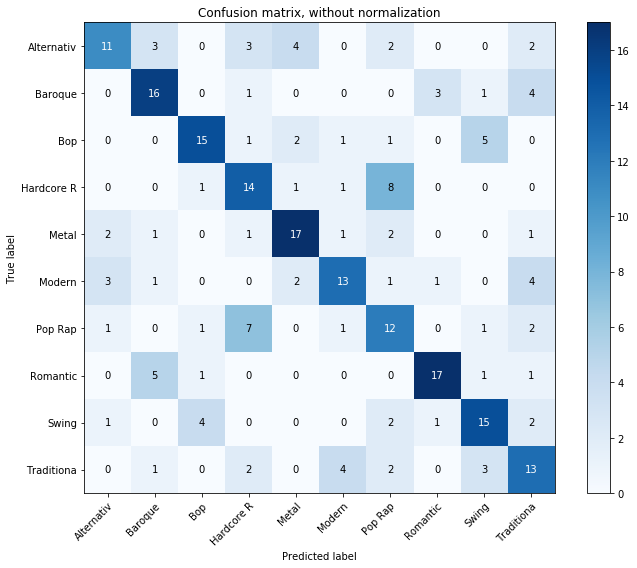

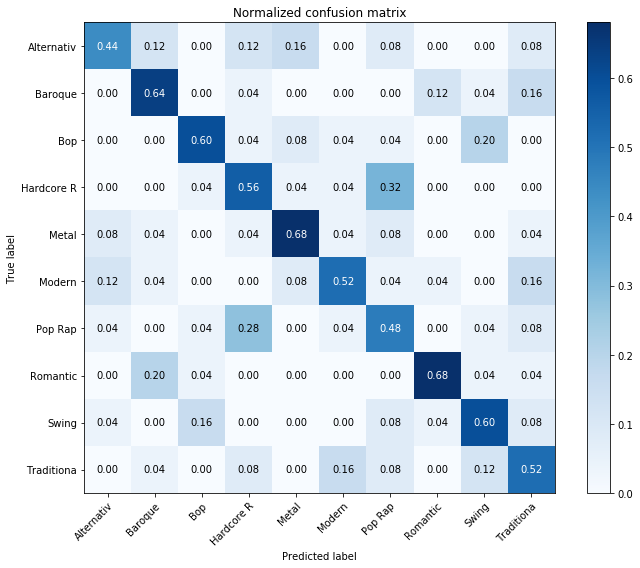

In [21]:
np.set_printoptions(precision=2)
plot_confusion_matrix(labels_1hot, predicted, classes=subgenres,
                      title='Confusion matrix, without normalization')
plot_confusion_matrix(labels_1hot, predicted, classes=subgenres, normalize=True,
                      title='Normalized confusion matrix')